# GFlowNet Ring Graph Generation Tutorial

This tutorial demonstrates how to train a GFlowNet to generate ring graphs - where each vertex has exactly two neighbors and the edges form a single cycle containing all vertices.


## Setup

Let's first import all the necessary libraries:

In [1]:
import math
import time

import matplotlib.pyplot as plt
import torch
from matplotlib import patches

from gfn.containers import ReplayBuffer
from gfn.gflownet.trajectory_balance import TBGFlowNet
from gfn.gym.graph_building import GraphBuildingOnEdges
from gfn.modules import DiscreteGraphPolicyEstimator
from gfn.states import GraphStates
from gfn.utils.modules import GraphEdgeActionGNN

torch.random.manual_seed(7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/oyounis-iit.local/anaconda3/envs/torchgfn/lib/python3.11/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._show_config()


## Defining the Reward Function

A crucial component of GFlowNet training is the reward function that evaluates whether a generated graph forms a valid ring structure. We define here the function computing the reward for it:


In [2]:

def reward_function(states: GraphStates) -> torch.Tensor:
    """Compute reward for undirected ring graphs.

    This function evaluates if a graph forms a valid undirected ring (cycle).
    A valid undire|cted ring must satisfy these conditions:
    1. Each node must have exactly two neighbors (degree = 2)
    2. The graph must form a single connected cycle including all nodes.

    The algorithm:
    1. Checks that all nodes have degree 2
    2. Performs a traversal starting from node 0, following edges
    3. Checks if the traversal visits all nodes and returns to start

    Args:
        states: A batch of graph states to evaluate

    Returns:
        A tensor of rewards with the same batch shape as states
    """
    if states.tensor.edge_index.numel() == 0:
        return torch.full(states.batch_shape, 1e-4)

    out = torch.full((len(states),), 1e-4)  # Default reward.

    for i in range(len(states)):
        graph = states[i]
        if graph.tensor.num_nodes == 0:
            continue
        adj_matrix = torch.zeros(graph.tensor.num_nodes, graph.tensor.num_nodes)
        adj_matrix[graph.tensor.edge_index[0], graph.tensor.edge_index[1]] = 1
        adj_matrix[graph.tensor.edge_index[1], graph.tensor.edge_index[0]] = 1

        # In an undirected ring, every vertex should have degree 2.
        if not torch.all(adj_matrix.sum(dim=1) == 2):
            continue

        # Traverse the cycle starting from vertex 0.
        start_vertex = 0
        visited = [start_vertex]
        neighbors = torch.where(adj_matrix[start_vertex] == 1)[0]
        if neighbors.numel() == 0:
            continue
        # Arbitrarily choose one neighbor to begin the traversal.
        current = neighbors[0].item()
        prev = start_vertex

        while True:
            if current == start_vertex:
                break
            visited.append(int(current))
            current_neighbors = torch.where(adj_matrix[int(current)] == 1)[0]
            # Exclude the neighbor we just came from.
            current_neighbors_list = [n.item() for n in current_neighbors]
            possible = [n for n in current_neighbors_list if n != prev]
            if len(possible) != 1:
                break
            next_node = possible[0]
            prev, current = current, next_node

        if current == start_vertex and len(visited) == graph.tensor.num_nodes:
            out[i] = 100.0

    return out.view(*states.batch_shape)

## Visualization Function

To understand what the model is generating, we need a visualization function:

In [3]:
def render_states(states: GraphStates, state_evaluator: callable):
    """Visualize a batch of graph states as ring structures.

    This function creates a matplotlib visualization of graph states, rendering them
    as circular layouts with nodes positioned evenly around a circle.

    The visualization includes:
    - Circular positioning of nodes
    - Drawing edges between connected nodes
    - Displaying the reward value for each graph

    Args:
        states: A batch of graphs to visualize
        state_evaluator: Function to compute rewards for each graph
    """
    rewards = state_evaluator(states)
    fig, ax = plt.subplots(2, 4, figsize=(15, 7))
    for i in range(8):
        current_ax = ax[i // 4, i % 4]
        state = states[i]
        n_circles = state.tensor.num_nodes
        radius = 5
        xs, ys = [], []
        for j in range(n_circles):
            angle = 2 * math.pi * j / n_circles
            x = radius * math.cos(angle)
            y = radius * math.sin(angle)
            xs.append(x)
            ys.append(y)
            current_ax.add_patch(
                patches.Circle((x, y), 0.5, facecolor="none", edgecolor="black")
            )

        edge_index = states[i].tensor.edge_index

        for edge in edge_index.T:
            start_x, start_y = xs[edge[0]], ys[edge[0]]
            end_x, end_y = xs[edge[1]], ys[edge[1]]
            dx = end_x - start_x
            dy = end_y - start_y
            length = math.sqrt(dx**2 + dy**2)
            dx, dy = dx / length, dy / length

            circle_radius = 0.5

            start_x += dx * circle_radius
            start_y += dy * circle_radius
            end_x -= dx * circle_radius
            end_y -= dy * circle_radius
            current_ax.plot([start_x, end_x], [start_y, end_y], color="black")

        current_ax.set_title(f"State {i}, $r={rewards[i]:.2f}$")
        current_ax.set_xlim(-(radius + 1), radius + 1)
        current_ax.set_ylim(-(radius + 1), radius + 1)
        current_ax.set_aspect("equal")
        current_ax.set_xticks([])
        current_ax.set_yticks([])

    plt.show()

## Environment and policy estimator 

Let's define the environment using the our reward function. The action space for the GraphBuildingOnEdges is discrete, so we will also define the DiscretePolicyEstimator for it. As typical with GFlowNets, we will have two policies, one for the forward step and one for backward.

In [4]:
env = GraphBuildingOnEdges(
    n_nodes=5,
    state_evaluator=reward_function,
    directed=False,
    device=device,
)


pf = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=False,
        num_conv_layers=2,
        num_edge_classes=env.num_edge_classes,
    )
)
pb = DiscreteGraphPolicyEstimator(
    module=GraphEdgeActionGNN(
        env.n_nodes,
        directed=False,
        is_backward=True,
        num_conv_layers=2,
        num_edge_classes=env.num_edge_classes,
    ),
    is_backward=True,
)

## Training

Let's write a training loop with Trajectory-Based GFlowNets, and using a ReplayBuffer. Depending on your machine, this may take a while. 



In [ ]:
lr = 1e-3
batch_size = 128
n_iterations = 200
n_nodes = 5


gflownet = TBGFlowNet(pf, pb).to(device)
optimizer = torch.optim.Adam(gflownet.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

replay_buffer = ReplayBuffer(
    env,
    capacity=batch_size,
    prioritized=True,
)

losses = []
ring_percentages = []

print(f"Starting training on {device} device...")
print(f"Training parameters: n_nodes={n_nodes}")

t1 = time.time()
for iteration in range(n_iterations):
    trajectories = gflownet.sample_trajectories(
        env,
        n=batch_size,
        save_logprobs=True,
    )
    training_samples = gflownet.to_training_samples(trajectories)

    # Collect rewards for reporting.
    terminating_states = training_samples.terminating_states
    assert isinstance(terminating_states, GraphStates)
    rewards = reward_function(terminating_states)

    with torch.no_grad():
        replay_buffer.add(training_samples)
        if iteration > 20:
            training_samples = training_samples[:batch_size // 2]
            buffer_samples = replay_buffer.sample(
                n_trajectories=batch_size // 2
            )
            training_samples.extend(buffer_samples)  # type: ignore

    optimizer.zero_grad()
    loss = gflownet.loss(env, training_samples, recalculate_all_logprobs=True)
    pct_rings = torch.mean(rewards > 0.1, dtype=torch.float) * 100
    ring_percentages.append(pct_rings.item())
    
    if iteration % 10 == 0:
        print(
            "Iteration {} - Loss: {:.02f}, rings: {:.0f}%".format(
                iteration, loss.item(), pct_rings
            )
        )
        
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())

t2 = time.time()
print(f"Training completed in {t2 - t1:.2f} seconds")
print(f"Final percentage of valid rings: {ring_percentages[-1]:.0f}%")



## Sampling from Trained Models

We can use our trained models to generate ring graphs, and visualize them:

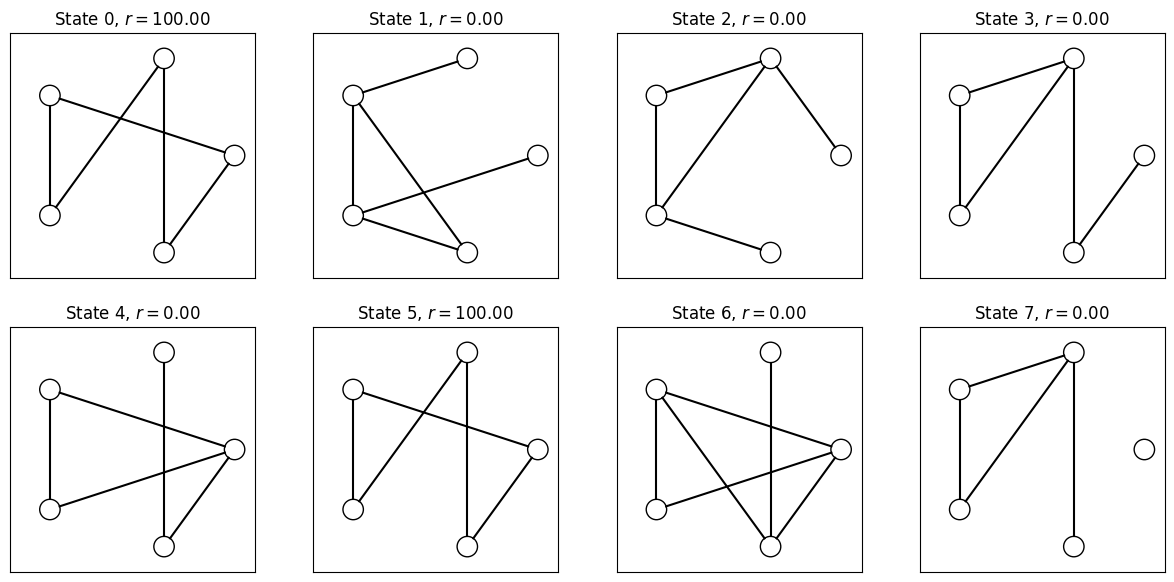

In [6]:
trajectories = gflownet.sample_trajectories(env, n=8)
terminating_states = trajectories.terminating_states
render_states(terminating_states, reward_function)  # type: ignore

## Conclusion

In this tutorial, we explored how to train a GFlowNet to generate ring graphs.

GFlowNets provide a powerful framework for learning to generate graphs with desired properties by defining utility through reward functions; higher rewards correspond to higher utility. While we focused on generating ring structures in this example, GFlowNets can be readily adapted to generate diverse graph types, including trees, grids, and complex molecular structures. This flexibility makes GFlowNets particularly valuable for applications requiring structured data generation with specific objectives.